In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import pickle
import matplotlib.pyplot as plt

In [3]:
from data.generate_synthetic_data import generate_synthetic_dynamics

from gpslds.kernels import Linear, MixtureBases
from gpslds.transition import SparseGP
from gpslds.likelihoods import PoissonProcess
from gpslds.initialization import initialize_zs
from gpslds.quadrature import GaussHermiteQuadrature

# Load in dataset and pLDS emissions

In [4]:
data_path = "data/synthetic_data.pkl"
with open(data_path, 'rb') as f:
    dataset = pickle.load(f)
dt, all_xs, all_spikes, C, d = dataset

emissions_path = "data/synthetic_plds_emissions.pkl"
with open(emissions_path, 'rb') as f:
    elbos, q, C_plds, d_plds = pickle.load(f)
C_plds = jnp.array(C_plds)
d_plds = jnp.array(d_plds)

In [5]:
# select subset of data for fitting
n_trials = 30
inds_to_select = jnp.concatenate((jnp.arange(int(n_trials/2)), jnp.arange(int(len(all_xs)/2), int(len(all_xs)/2)+int(n_trials/2))))
xs = all_xs[inds_to_select]
spikes = all_spikes[inds_to_select]

In [6]:
K = xs.shape[-1]
_, n_timesteps, D = spikes.shape
t_max = n_timesteps * dt

# Plot true dynamics, latents, and observations

Text(0, 0.5, '$x_2$')

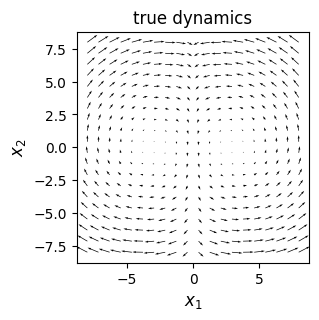

In [7]:
# visualize flow field of true dynamics
xlim = 8
N = 20
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, N),
    jnp.linspace(-xlim, xlim, N)
)
Xs = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)
f_Xs = vmap(generate_synthetic_dynamics)(Xs)
f_Xs_grid = f_Xs.reshape(N, N, 2)

# plot latent states for first few trials
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.quiver(X1, X2, f_Xs_grid[...,0], f_Xs_grid[...,1], angles='xy')
ax.set_title(f"true dynamics", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

Text(0, 0.5, '$x_2$')

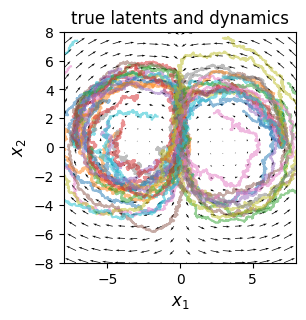

In [8]:
# plot true latent states with true dynamics
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.quiver(X1, X2, f_Xs_grid[...,0], f_Xs_grid[...,1], angles='xy')
for i in range(n_trials):
    ax.plot(xs[i,:,0], xs[i,:,1], alpha=0.5)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title(f"true latents and dynamics", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

Text(0, 0.5, '$x_1(t), x_2(t)$')

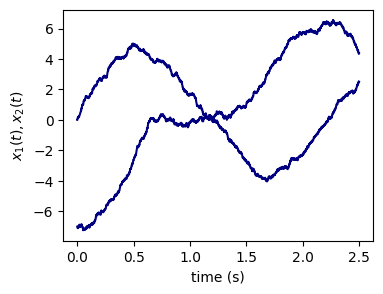

In [9]:
# plot observations for one trial
trial_idx = 0
t_grid = jnp.arange(0, t_max, dt)

fig, ax = plt.subplots(figsize=(4, 3))
for i in range(K):
    ax.plot(t_grid,xs[trial_idx,:,i], color="navy")
ax.set_xlabel("time (s)")
ax.set_ylabel(r"$x_1(t), x_2(t)$")

# Initialize the model

In [10]:
# initialize quadrature object and kernel
gh_quad = GaussHermiteQuadrature(K, n_quad=6)
num_bases = 3
basis_set = lambda x: jnp.array([1., x[0], x[1]])
linear_kernel = Linear(gh_quad)
kernel = MixtureBases(gh_quad, linear_kernel, basis_set=basis_set)

# initialize inducing points and function
zs_lim, M_per_dim = 4, 4
zs = initialize_zs(K, zs_lim, M_per_dim)
M = zs.shape[0]
fn = SparseGP(zs, kernel)

# initialize likelihood
t_mask = jnp.ones((n_trials, n_timesteps))
trial_mask = jnp.ones((n_trials, n_timesteps))
likelihood = PoissonProcess(spikes, t_mask, dt, gh_quad, link='softplus')

In [11]:
# initialize kernel hyperparameters
key = jr.PRNGKey(1)
key_W, key_fp = jr.split(key, 2)
num_states = 2
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64)
fp_init = tfd.Normal(0, 1).sample((num_states, K), seed=key_fp).astype(jnp.float64)
tau_init = 0.5
kernel_params_init = {
    "linear_params": [{"fixed_point": fp_init[i]} for i in range(num_states)],
    "log_tau": jnp.log(tau_init),
    "W": W_init
}

# initialize initial conditions for latents from Poisson LDS
x0_init_params = jnp.stack([q.mean_continuous_states[i][0] for i in inds_to_select])

# initialize output parameters from Poisson LDS
output_params_init = {'C': C_plds, 'd': d_plds}

# zero inputs
inputs = jnp.zeros((n_trials, n_timesteps, 1))

# Fit model

In [12]:
from gpslds.em import fit_variational_em

key = jr.PRNGKey(0) # doesn't matter here, since we are using batch_size=n_trials
n_iters = 25
decay, forgetting_rate = 50, -0.9
learning_rates = (decay + jnp.arange(1, 1 + n_iters)) ** (forgetting_rate)
result = fit_variational_em(key, 
                            K, 
                            dt, 
                            fn, 
                            likelihood, 
                            trial_mask, 
                            inputs, 
                            output_params_init,
                            kernel,
                            kernel_params_init, 
                            m0=x0_init_params,
                            mu0=x0_init_params,
                            n_iters=n_iters,
                            n_iters_e=15, 
                            n_iters_m=150, 
                            learning_rates=learning_rates,
                            batch_size=n_trials)

ms, Ss, As, bs, B, q_u_mu, q_u_sigma, output_params, kernel_params, elbos = result

iter: 0, elbo = 60246.50633075446
iter: 1, elbo = 60587.663393247
iter: 2, elbo = 60614.54994743322
iter: 3, elbo = 60629.09502763665
iter: 4, elbo = 60639.41103973296
iter: 5, elbo = 60647.117548537084
iter: 6, elbo = 60653.07050393593
iter: 7, elbo = 60657.79575679772
iter: 8, elbo = 60661.63593379382
iter: 9, elbo = 60664.823420951565
iter: 10, elbo = 60667.51999330406
iter: 11, elbo = 60669.840794287906
iter: 12, elbo = 60671.86919989349
iter: 13, elbo = 60673.66649771195
iter: 14, elbo = 60675.27830951566
iter: 15, elbo = 60676.73904442953
iter: 16, elbo = 60678.07496127484
iter: 17, elbo = 60679.306363075935
iter: 18, elbo = 60680.44908059184
iter: 19, elbo = 60681.515658278375
iter: 20, elbo = 60682.51612559086
iter: 21, elbo = 60683.45859097673
iter: 22, elbo = 60684.34969152609
iter: 23, elbo = 60685.19492274038
iter: 24, elbo = 60685.998472135405


# Plot results

In [13]:
# compute necessary rotation matrices
from gpslds.utils import get_transformation_for_latents
P = get_transformation_for_latents(C, output_params['C'])

# rotate inferred latents
ms_rot = (P @ ms[...,None]).squeeze(-1)
Ss_rot = P @ Ss @ P.T

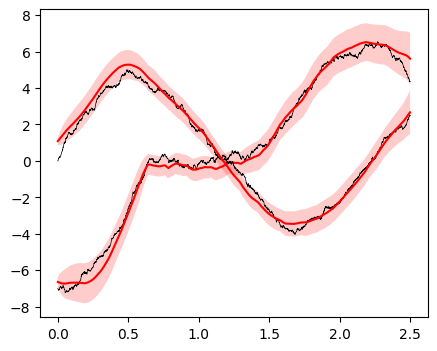

In [14]:
# plot the latent path for an example trial
trial_idx = 0
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
t_grid = jnp.arange(0, t_max, dt)
for i in range(K):
    ax.plot(t_grid,xs[trial_idx][:,i],color='black',linewidth=0.5,label='x(t)')
    ax.plot(t_grid,ms_rot[trial_idx,:,i], color='red', label='$m_x(t)$')
    ax.fill_between(t_grid, ms_rot[trial_idx,:,i]+2*jnp.sqrt(Ss_rot[trial_idx,:,i,i]),
                    ms_rot[trial_idx,:,i]-2*jnp.sqrt(Ss_rot[trial_idx,:,i,i]), facecolor='red', alpha=0.2)

In [15]:
# visualize learned dynamics
from gpslds.utils import get_posterior_f_mean, get_posterior_f_var

# generate grid in true generative space
xlim = 8
n_grid = 15
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid),
    jnp.linspace(-xlim, xlim, n_grid)
)
Xs_rot = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)

# rotate to gpslds inferred space
Xs = jnp.linalg.solve(P, Xs_rot.T).T 
Xs_grid = Xs.reshape(n_grid, n_grid, -1)

f_mean = get_posterior_f_mean(kernel.K, kernel_params, Xs, zs, q_u_mu)
f_mean_rot = (P @ f_mean[...,None]).squeeze(-1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

Text(0, 0.5, '$x_2$')

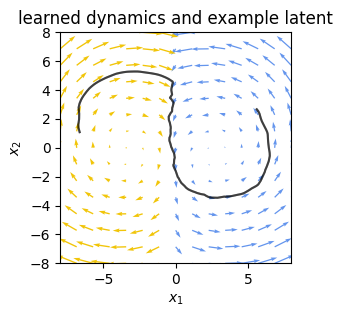

In [16]:
# learned dynamics plot
from gpslds.utils import get_most_likely_state

trial_idx = 0

fig, ax = plt.subplots(figsize=(3, 3))
most_likely_state = get_most_likely_state(kernel.construct_pi, kernel_params, Xs)
colors = ["cornflowerblue", "#F1C509"]

for i in range(num_states):
    state_inds = (most_likely_state == i).astype(bool)
    ax.quiver(Xs_rot[state_inds,0], Xs_rot[state_inds,1], f_mean_rot[state_inds,0], f_mean_rot[state_inds,1], color=colors[i])
    ax.plot(ms_rot[trial_idx,:,0], ms_rot[trial_idx,:,1], 'k', alpha=0.5)
ax.set_aspect(1.)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title("learned dynamics and example latent")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

In [17]:
# compute posterior variance on a finer grid
# generate grid in true generative space
xlim = 8
n_grid_fine = 40
X1_fine, X2_fine = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid_fine),
    jnp.linspace(-xlim, xlim, n_grid_fine)
)
Xs_rot_fine = jnp.column_stack([X1_fine.ravel(), X2_fine.ravel()]) # (N**2, 2)
Xs_rot_grid_fine = Xs_rot_fine.reshape(n_grid_fine, n_grid_fine, -1)

# rotate to gpslds inferred space
Xs_fine = jnp.linalg.solve(P, Xs_rot_fine.T).T 
Xs_grid_fine = Xs_fine.reshape(n_grid_fine, n_grid_fine, -1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs_fine, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

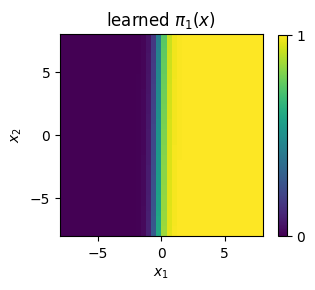

In [18]:
# learned pis plot
from gpslds.utils import get_learned_pis

learned_pis = get_learned_pis(kernel.construct_pi, kernel_params, Xs_fine)
learned_pis_grid = learned_pis.reshape(n_grid_fine, n_grid_fine, -1)

fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(learned_pis_grid[:,:,0], origin='lower', extent=[-xlim, xlim, -xlim, xlim])
ax.set_aspect(1.)
ax.set_xticks([-5, 0, 5])
ax.set_yticks([-5, 0, 5])
ax.set_title(r"learned $\pi_1(x)$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0, 1])

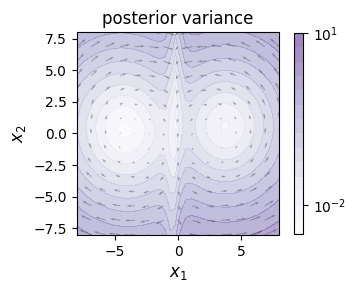

In [19]:
from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(3, 3))

levels = 10**(jnp.linspace(-2.5, 1, 15))
contour = ax.contourf(X1_fine, X2_fine, f_det_rot.reshape(n_grid_fine, n_grid_fine), levels=levels, alpha=0.5, locator=ticker.LogLocator(), cmap='Purples')
ax.quiver(Xs_rot[:,0], Xs_rot[:,1], f_mean_rot[:,0], f_mean_rot[:,1], color='black', alpha=0.3)

ax.set_aspect(1)
ax.set_title("posterior variance", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.locator = ticker.LogLocator(10)
cbar.set_ticks([1e-2, 1e1])